In [29]:
import os
import torch
import torchvision
from torch.utils.data import  DataLoader
from dataset import UntrimmedDataset

data_root = os.path.join(os.getcwd(), 'Untrimmed_accline')
n_fft =64
hop_length = int(n_fft/4)
device = 'cpu'
feature_size = 32

squeeze_net = torchvision.models.squeezenet1_1(progress=True).to(device)
squeeze_net.classifier = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=(1,1)),
    torch.nn.Flatten(),
    torch.nn.Linear(512, feature_size, bias=True))
backbone =  squeeze_net

dataset = UntrimmedDataset(root_dir=data_root,
                               kernel_size=1024,
                               stride=256,
                               device='cpu',
                               n_fft=n_fft,
                               hop_length=hop_length)
    
dataloader = DataLoader(dataset, batch_size=4)

In [30]:
print(len(dataset))

77


In [31]:

for stft, class_info, is_new in dataloader:
    print(f'stft : {stft.shape}')
    print(f'class_info : {class_info}')
    print(f'is_new : {is_new}')
    
    a_stft = stft[0]
    
    break

stft : torch.Size([4, 3, 61, 64])
class_info : tensor([6., 6., 6., 6.], dtype=torch.float64)
is_new : tensor([ True, False, False, False])


a_stft.shape : torch.Size([3, 61, 64])


/Users/lilmae/anaconda3/envs/vibration/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


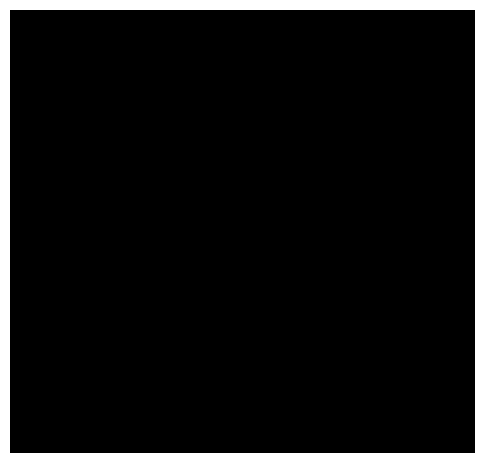

In [32]:
import matplotlib.pyplot as plt
print(f'a_stft.shape : {a_stft.shape}')

tensor_rgb = a_stft.permute(1, 2, 0)

plt.figure(figsize=(6, 6))
plt.imshow(tensor_rgb)
plt.axis('off')
plt.show()